#### In this notebook, preliminary visuals include boxplots and univariate visuals. Data exploration includes cleaning unknown entries and organizing the features into more efficient groups. 

# Create Project

## Libraries and Tools

In [60]:
#import libraries 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

##additional visuals
from matplotlib.ticker import StrMethodFormatter
import matplotlib.ticker as ticker

## Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

#Classification Libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

# Classification Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, RocCurveDisplay
## Tree Model Visualization
from sklearn.tree import plot_tree

## Import Models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor

##Set up configuation display
from sklearn import set_config
set_config(display='diagram') # 'text' or 'diagram'}


In [2]:
#load data and create dataframe
filename2 = 'Data/adult[1].csv'
adult_df = pd.read_csv(filename2)

## Functions

In [47]:
# function for numeric values
def plot_numeric(df,col):
  ## make the figure and axes sharing the same x-axis
  fig, axes = plt.subplots(nrows=2, figsize=(10,5), sharex=True)

  ## Use seaborn plots with ax=axes[i]
  sns.histplot(data=df,x = col,ax = axes[0])
  mean_value = df[col].mean()
  axes[0].axvline(mean_value,color='red', ls='--', 
           label=f"Mean Value = ${mean_value:,.2f}",);

  med_value = df[col].median()
  axes[0].axvline(med_value,color='black', ls='--', 
           label=f"Median Value = ${med_value:,.2f}");


  sns.boxplot(data=df, x = col, ax = axes[1])

  ## Updating title of top graph 
  axes[0].set_title(f'EDA for {col}')

  ## Fixing any overlapping labels and showing
  plt.tight_layout()
  plt.show()

In [22]:
#function for categorical values
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):
 
  # Make a copy of the dataframe and fillna 
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing 
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot 
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}", fontweight='bold')
  
  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()
    
  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax

In [23]:
# function for statistics

def column_statistics(column_name, max_unique_values_to_disply=20):
    # Display the count of missing values for this column
    print(f'Missing Values: {df[column_name].isna().sum()} ({round((df[column_name].isna().sum())/(df.shape[0])*100,1)})%')

    # Determine Outliers - Only if this is a numeric column
    if (df[column_name].dtype == 'int64') | (df[column_name].dtype == 'float64'):
        # Create outlier filters
        q1 = df[column_name].quantile(0.25) # 25th percentile
        q3 = df[column_name].quantile(0.75) # 75th percentile
        iqr = q3 - q1 # Interquartile range
        low_limit = q1 - (1.5 * iqr) # low limit
        high_limit = q3 + (1.5 * iqr) # high limit
        # Create outlier dataframes
        low_df = df[(df[column_name] < low_limit)]
        high_df = df[(df[column_name] > high_limit)]
        # Calculate the outlier counts and percentages
        low_oulier_count = low_df.shape[0]
        low_outlier_percentge = round(((low_oulier_count)/(df.shape[0])*100),1)
        high_oulier_count = high_df.shape[0]
        high_outlier_percentge = round(((high_oulier_count)/(df.shape[0])*100),1)
        # Display the outlier counts.
        print(f'Outliers: {low_oulier_count} ({low_outlier_percentge})% low, {high_oulier_count} ({high_outlier_percentge})% high')
    
     
   
    # Display the count of unique values for this column
    print(f'Individual Unique values: {df[column_name].nunique()}')

    # Display the unique values including Nan and their counts for this column,
    # if the number of unique values is below the function parameter
    if df[column_name].nunique() < max_unique_values_to_disply:
        print(df[column_name].value_counts(dropna=False))
        
    # determine  specific percentages
    specific_percent=df[column_name].value_counts()/df[column_name].count()*100
    print (f'The specific percentages:')
    display(specific_percent)

     

# Data Cleaning and Exploration

In [3]:
#  Inspect the first (5) rows of the dataframe
adult_df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [4]:
## Display the number of rows and columns for the dataframe
adult_df.shape
print(f'There are {adult_df.shape[0]} rows, and {adult_df.shape[1]} columns.')
print(f'The rows represent {adult_df.shape[0]} participants.') 
print(f'The columns represent {adult_df. shape[1]-1} features and 1 target variable.')

There are 48842 rows, and 15 columns.
The rows represent 48842 participants.
The columns represent 14 features and 1 target variable.


In [5]:
# check the info
adult_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


#### All data types appear correct and there are no unnecessary rows. 

In [6]:
# check the info
adult_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [7]:
# Display the number of duplicate rows
print(f'There are {adult_df.duplicated().sum()} duplicate rows.')

There are 52 duplicate rows.


In [8]:
# Drop duplicate rows
adult_df = adult_df.drop_duplicates()
print(f'There are {adult_df.duplicated().sum()} duplicate rows.')

There are 0 duplicate rows.


In [9]:
# Checking for missing values
adult_df.isna().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

## Check  column types for inconsistencies

In [10]:
# Check the numeric columns for inconsistencies
adult_df.describe(include="number")

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48790.000000,4.879000e+04,48790.000000,48790.000000,48790.000000,48790.000000
mean,38.652798,1.896690e+05,10.078807,1080.217688,87.595573,40.425886
std,13.708493,1.056172e+05,2.570046,7455.905921,403.209129,12.392729
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175550e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781385e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376062e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [11]:
# Check the object columns for inconsistencies
adult_df.describe(include="object")

,workclass,education,marital-status,occupation,relationship,race,gender,native-country,income
count,48790,48790,48790,48790,48790,48790,48790,48790,48790
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,33860,15770,22366,6165,19703,41714,32614,43792,37109


#### To clean data there are several steps
  1. Remove educational numerical
  2. Remove "?" from data set
  3. Create hours per week based on part time and full time
  4. Create continent groups
  5. ???

In [12]:
#create a copy
df=adult_df.copy()

In [13]:
# drop educational-num column because it is redundant 
df.drop('educational-num', inplace = True, axis =1)

In [14]:
# drop the values of "?"
df = df[df != '?']

### hours per week cleaning

In [15]:
# create employment status based on hours per week
part_time_filter = df['hours-per-week']< 35
print(sum(part_time_filter))
part_time_filter.replace(  {True: 'Part time', False: 'Full time'}  ).value_counts()
df['employment_status'] = part_time_filter.replace(  {True: 'Part time', False: 'Full time'}  ).value_counts()

8386


In [41]:
df['employment_status'].value_counts

<bound method IndexOpsMixin.value_counts of 0       NaN
1       NaN
2       NaN
3       NaN
5       NaN
         ..
48837   NaN
48838   NaN
48839   NaN
48840   NaN
48841   NaN
Name: employment_status, Length: 45964, dtype: float64>

In [16]:
# drop the hours-per-week column
df.drop('hours-per-week', inplace = True, axis =1)

### native country cleaning

In [17]:
# drop values with 'South'
df = df[df != 'South']

In [18]:
#create region map dictionary
mapdictionary = {'Germany': 'Europe', 'United-States': 'US', 'Canada': 'North America',
                 'Philippines': 'Pacific', 'Mexico': 'North America', 'Puerto-Rico': 'Caribbean',
                 'El-Salvador': 'Latin America', 'India': 'India', 'Cuba': 'Caribbean',
                 'England': 'Europe', 'China': 'Asia', 'Jamaica': 'Caribbean',
                 'Italy': 'Europe', 'Dominican-Republic': 'Caribbean', 'Japan': 'Asia',
                 'Poland': 'Europe', 'Vietnam': 'Asia', 'Guatemala': 'Latin America',
                 'Columbia': 'Latin America', 'Haiti': 'Caribbean', 'Portugal': 'Europe',
                 'Taiwan': 'Asia', 'Iran':'Asia', 'Greece': 'Europe', 'Nicaragua': 'Latin America',
                 'Peru': 'Latin America', 'Ecuador': 'Latin America', 'France': 'Europe',
                 'Ireland': 'Europe', 'Hong': 'Asia', 'Thailand': 'Asia', 'Cambodia': 'Asia',
                 'Trinadad&Tobago': 'Caribbean', 'Outlying-US(Guam-USVI-etc)': 'US',
                 'Laos': 'Asia', 'Scotland': 'Europe', 'Honduras': 'Latin America',
                 'Hungary': 'Europe', 'Holand-Netherlands': 'Europe', 'Yugoslavia': 'Europe' }
df['regions'] = df['native-country'].replace(mapdictionary)

In [19]:
# check values
df['regions'].value_counts()

US               43815
North America     1125
Europe             780
Caribbean          633
Asia               535
Latin America      486
Pacific            294
India              151
Name: regions, dtype: int64

In [20]:
# drop educational-num column because it is redundant 
df.drop('native-country', inplace = True, axis =1)

In [21]:
# show new columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48790 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                48790 non-null  int64  
 1   workclass          45995 non-null  object 
 2   fnlwgt             48790 non-null  int64  
 3   education          48790 non-null  object 
 4   marital-status     48790 non-null  object 
 5   occupation         45985 non-null  object 
 6   relationship       48790 non-null  object 
 7   race               48790 non-null  object 
 8   gender             48790 non-null  object 
 9   capital-gain       48790 non-null  int64  
 10  capital-loss       48790 non-null  int64  
 11  income             48790 non-null  object 
 12  employment_status  0 non-null      float64
 13  regions            47819 non-null  object 
dtypes: float64(1), int64(4), object(9)
memory usage: 5.6+ MB


# Check individual columns

## Column 0: Age

In [54]:
column_statistics('age')

Missing Values: 0 (0.0)%
Outliers: 0 (0.0)% low, 273 (0.6)% high
Individual Unique values: 74
The specific percentages:


36    2.854408
31    2.826125
33    2.826125
35    2.813071
34    2.756505
        ...   
88    0.013054
85    0.010878
89    0.002176
87    0.002176
86    0.002176
Name: age, Length: 74, dtype: float64

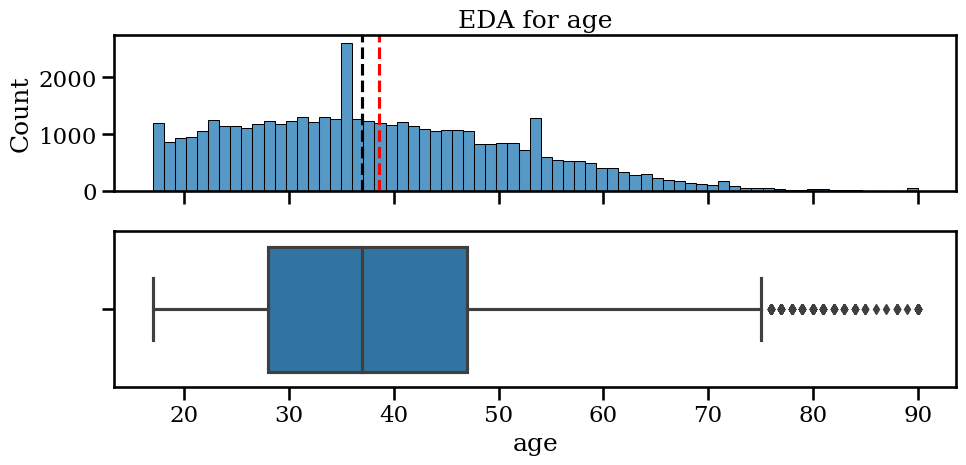

In [55]:
plot_numeric(df,'age')

### Summary: Age
- The median age is between 35 and 40 and the data obscures seniors.

## Column 1: workclass

In [24]:
# Display column statistics
column_statistics('workclass', 10)

Missing Values: 2795 (5.7)%
Individual Unique values: 8
Private             33860
Self-emp-not-inc     3861
Local-gov            3136
NaN                  2795
State-gov            1981
Self-emp-inc         1694
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64
The specific percentages:


Private             73.616697
Self-emp-not-inc     8.394391
Local-gov            6.818132
State-gov            4.306990
Self-emp-inc         3.683009
Federal-gov          3.113382
Without-pay          0.045657
Never-worked         0.021741
Name: workclass, dtype: float64

In [25]:
# drop without pay and never worked because  of small quanity
#drop never worked and without pay because irrelevant for target
df = df[df["workclass"].str.contains("Without-pay") == False]
df = df[df["workclass"].str.contains("Never-worked") == False]

In [26]:
df['workclass'].value_counts()

Private             33860
Self-emp-not-inc     3861
Local-gov            3136
State-gov            1981
Self-emp-inc         1694
Federal-gov          1432
Name: workclass, dtype: int64

### Summary of workclass
- Most people are imployed privately at a 70% rate.

## Column 3: Education

In [27]:
# Display column statistics
column_statistics('education', 10)

Missing Values: 0 (0.0)%
Individual Unique values: 16
The specific percentages:


HS-grad         32.512401
Some-college    21.801845
Bachelors       16.884953
Masters          5.632669
Assoc-voc        4.301192
11th             3.548429
Assoc-acdm       3.322165
10th             2.695588
7th-8th          1.829693
Prof-school      1.762249
9th              1.494648
12th             1.298843
Doctorate        1.253155
5th-6th          1.013837
1st-4th          0.493865
Preschool        0.154469
Name: education, dtype: float64

#### Create educational groups based on the years of education. 

In [28]:
eddictionary = {'HS-grad': 'HS-grad', '1st-4th': 'Primary', '5th-6th': 'Primary',
                 '7th-8th': 'Middle School', '9th': 'Secondary', '12th': 'Secondary',
                 'Preschool': 'Primary', 'Doctorate': 'Graduate', 'Prof-school': 'Graduate',
                 '11th': 'secondary', 'Bachelors': 'College', 'Masters': 'Graduate',
                 'Some-college': 'HS-grad', 'Assoc-voc': 'College', 'Assoc-voc': 'College',
                 '10th': 'Secondary',  '11th': 'Secondary', 'Grad-school': 'Graduate', 'Assoc-acdm':'College' }
df['edstatus'] = df['education'].replace(eddictionary)
df['edstatus'].value_counts()

HS-grad          24965
College          11265
Secondary         4154
Graduate          3975
Middle School      841
Primary            764
Name: edstatus, dtype: int64

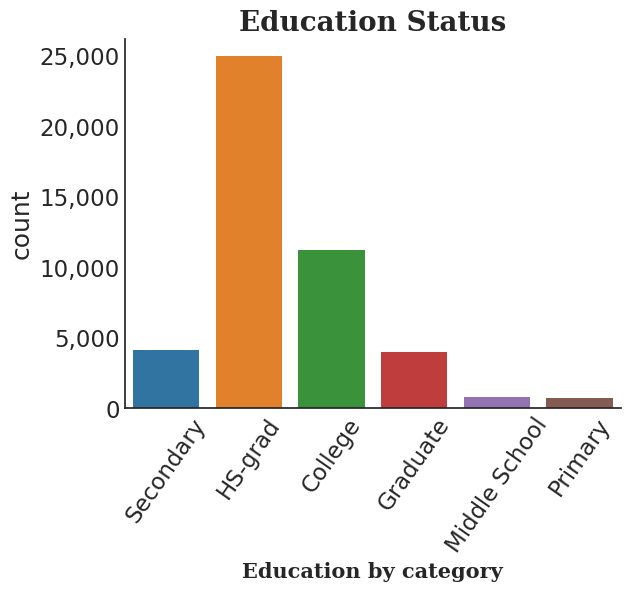

In [29]:
#create countplot for education
sns.set_context('talk')
with plt.style.context('seaborn-white'):
  fig, ax =plt.subplots()
plt.rcParams['font.family'] = 'serif'
ax = sns.countplot(data=df,x='edstatus')
ax.set_title('Education Status', fontfamily='serif',fontsize = 20, fontweight = 'bold');
ax.set_xlabel('Education by category', fontfamily= 'serif', fontsize = 15, fontweight = 'bold')
plt.xticks(rotation = 55);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False) 
#make commas in y ticks
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

#save figure
plt.savefig('Images/Educational Status', bbox_inches='tight')


### Summary: Education
- The highest category is HS grad with a marked difference with college. 

## Column 4: Education - numerical


#### deleted

## Column 5: Marital Status

In [30]:
# check column statistics
column_statistics('marital-status', 5)


Missing Values: 0 (0.0)%
Individual Unique values: 7
The specific percentages:


Married-civ-spouse       46.612566
Never-married            32.279610
Divorced                 13.836916
Separated                 3.117657
Widowed                   2.817422
Married-spouse-absent     1.266208
Married-AF-spouse         0.069620
Name: marital-status, dtype: float64

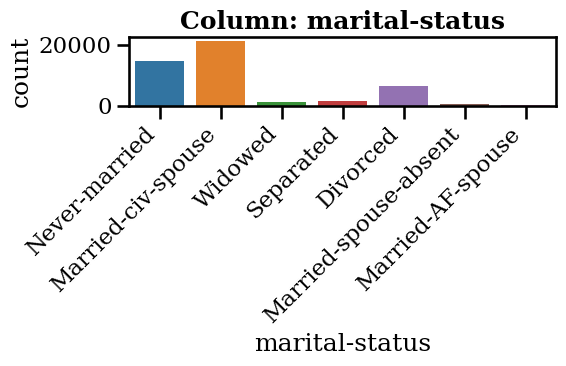

- NaN's Found: 0 (0.0%)
- Unique Values: 7
- Most common value: 'Married-civ-spouse' occurs 21425 times (46.61%)
- Not constant or quasi-constant.


In [31]:
#explore categorical  values for item type
explore_categorical(df, 'marital-status');

## Column 6: Occupation

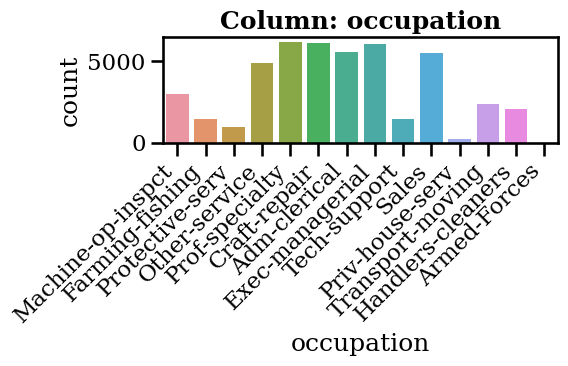

- NaN's Found: 0 (0.0%)
- Unique Values: 14
- Most common value: 'Prof-specialty' occurs 6165 times (13.41%)
- Not constant or quasi-constant.


In [32]:
#explore categorical  values for item type
explore_categorical(df, 'occupation');

In [33]:
#check stats
column_statistics('occupation', 5)

Missing Values: 0 (0.0)%
Individual Unique values: 14
The specific percentages:


Prof-specialty       13.412671
Craft-repair         13.273431
Exec-managerial      13.229919
Adm-clerical         12.189975
Sales                11.965886
Other-service        10.697502
Machine-op-inspct     6.559481
Transport-moving      5.121399
Handlers-cleaners     4.501349
Farming-fishing       3.213384
Tech-support          3.143765
Protective-serv       2.136455
Priv-house-serv       0.522148
Armed-Forces          0.032634
Name: occupation, dtype: float64

#### The biggest occupations are professional speciality  and craft-repair. 

## Column 7: Relationship

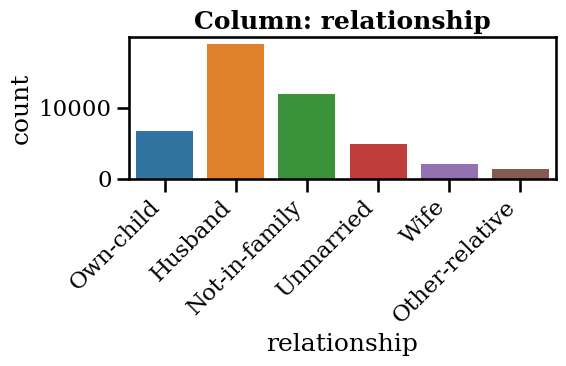

- NaN's Found: 0 (0.0%)
- Unique Values: 6
- Most common value: 'Husband' occurs 18984 times (41.3%)
- Not constant or quasi-constant.


In [34]:
#explore categorical  values for item type
explore_categorical(df, 'relationship');

In [35]:
column_statistics('relationship',5)

Missing Values: 0 (0.0)%
Individual Unique values: 6
The specific percentages:


Husband           41.301888
Not-in-family     25.872422
Own-child         14.550518
Unmarried         10.582195
Wife               4.647115
Other-relative     3.045862
Name: relationship, dtype: float64

### Summary
- There appears to be an imbalance between the husband and wife category that does not match actual US census statistics

## Column 8: Race

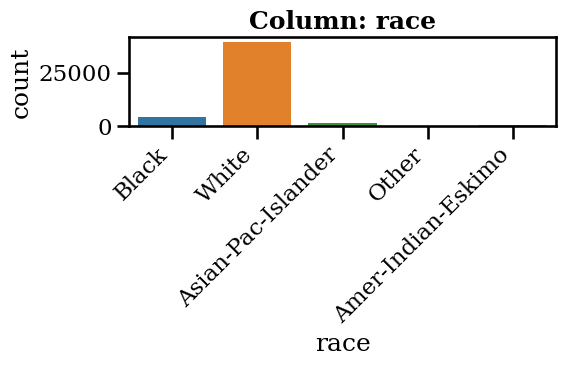

- NaN's Found: 0 (0.0%)
- Unique Values: 5
- Most common value: 'White' occurs 39381 times (85.68%)
- Not constant or quasi-constant.


In [36]:
#explore categorical  values for item type
explore_categorical(df, 'race');

In [37]:
column_statistics('race',5)

Missing Values: 0 (0.0)%
Individual Unique values: 5
The specific percentages:


White                 85.677922
Black                  9.470455
Asian-Pac-Islander     3.089374
Amer-Indian-Eskimo     0.946393
Other                  0.815856
Name: race, dtype: float64

### Summary
-The percentage of White is 85% however this does not match actual US census statistics at the time. Please look at the final summary and PowerPoint for more detailed information about the other racial/ethnic categories. 

## Column 9: Gender

In [42]:
#use function
column_statistics('gender',5)

Missing Values: 0 (0.0)%
Individual Unique values: 2
Male      31067
Female    14897
Name: gender, dtype: int64
The specific percentages:


Male      67.589853
Female    32.410147
Name: gender, dtype: float64

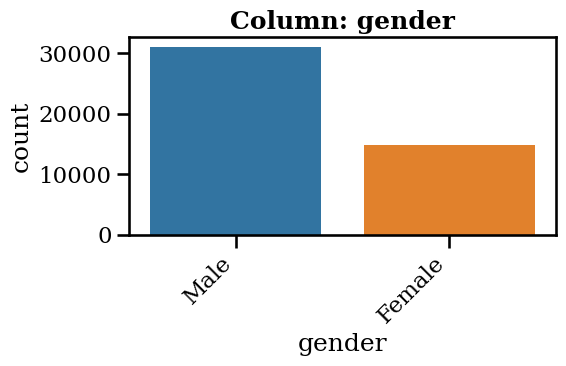

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'Male' occurs 31067 times (67.59%)
- Not constant or quasi-constant.


In [44]:
#explore categorical  values for item type
explore_categorical(df, 'gender');

### Summary: Gender
- US populations are closer to 50% for male and female. The final visuals will explore gender more closely.

## Column 10 Capital Gains

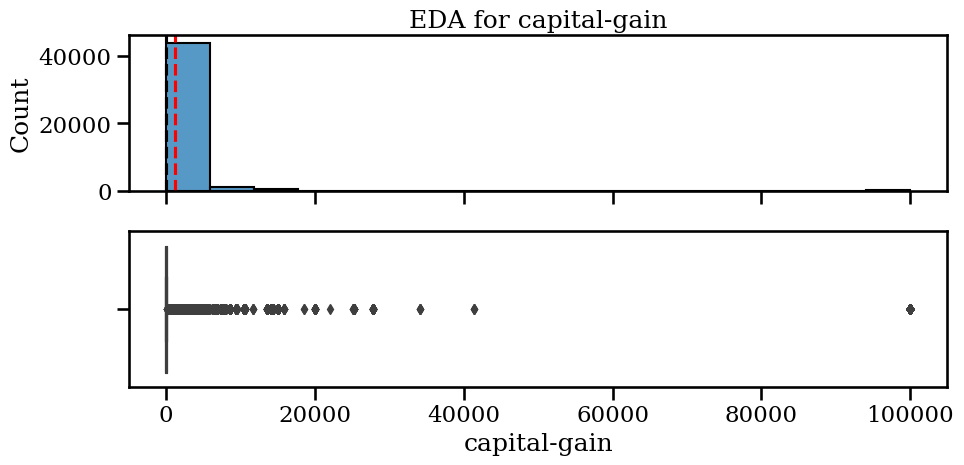

In [51]:
plot_numeric(df, 'capital-gain')

In [52]:
column_statistics('capital-gain')

Missing Values: 0 (0.0)%
Outliers: 0 (0.0)% low, 3859 (8.4)% high
Individual Unique values: 121
The specific percentages:


0        91.604299
15024     1.105213
7688      0.874598
7298      0.778870
99999     0.519972
           ...    
22040     0.002176
1731      0.002176
7262      0.002176
1639      0.002176
2387      0.002176
Name: capital-gain, Length: 121, dtype: float64

##  Column 12: Capital losses

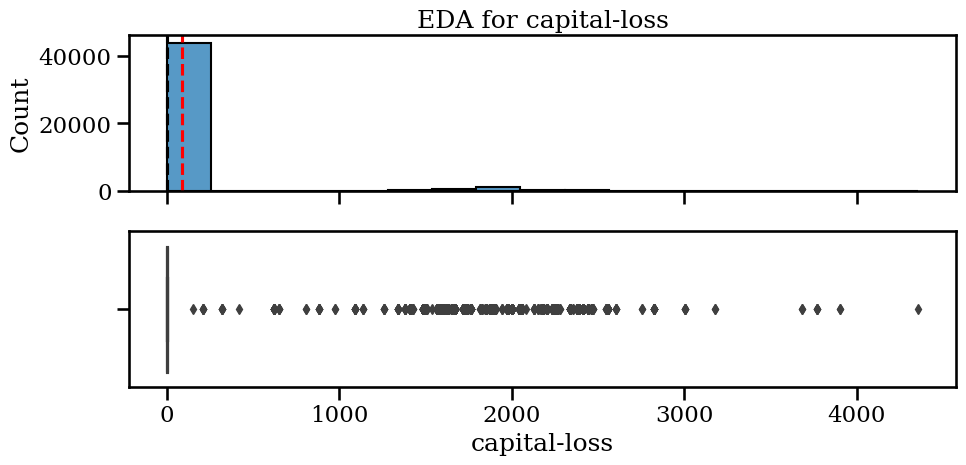

In [50]:
plot_numeric(df,'capital-loss')

In [53]:
column_statistics('capital-loss')

Missing Values: 0 (0.0)%
Outliers: 0 (0.0)% low, 2180 (4.7)% high
Individual Unique values: 97
The specific percentages:


0       95.257158
1902     0.654860
1977     0.546080
1887     0.498216
2415     0.154469
          ...    
2080     0.002176
419      0.002176
155      0.002176
1421     0.002176
2201     0.002176
Name: capital-loss, Length: 97, dtype: float64

### Summary: Capital Gains and Losses
- Capital gains are around 1000 but capital losses are nearly double that. 

## Column 13: Regions (native country)

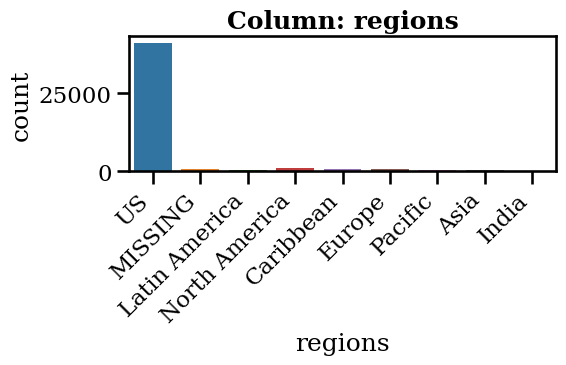

- NaN's Found: 911 (1.98%)
- Unique Values: 9
- Most common value: 'US' occurs 41258 times (89.76%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot: title={'center': 'Column: regions'}, xlabel='regions', ylabel='count'>)

In [56]:
explore_categorical(df, 'regions')

In [57]:
df['regions'].value_counts()

US               41258
North America     1058
Europe             738
Caribbean          603
Asia               500
Latin America      468
Pacific            281
India              147
Name: regions, dtype: int64

# Final Visuals summary

## Age

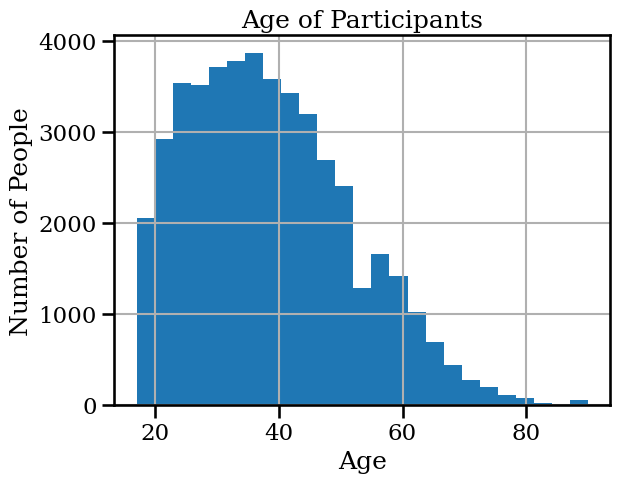

In [67]:
#histogram for Age
df['age'].hist(bins = 25)
plt.ticklabel_format(useOffset=False, style='plain')
plt.title ('Age of Participants')
plt.ylabel('Number of People')
plt.xlabel("Age");
plt.show()

1. There is a significant skew to the left. 
2. The majority of the participants are under 50.
3. There was also a significant number of people under 30. 4. Between the ages of 20 and 50, there are at least 2,500 people in each bin.
#### Action plan: The significant number of people in the bins under 50 merit more analysis.

## Race

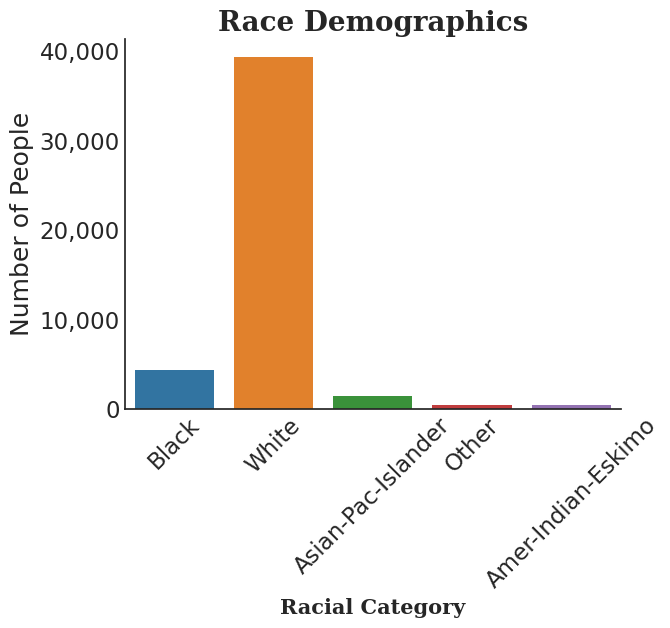

In [70]:
#create race countplot
sns.set_context('talk')
with plt.style.context('seaborn-white'):
  fig, ax =plt.subplots()
plt.rcParams['font.family'] = 'serif'
ax = sns.countplot(data=df,x='race')
ax.set_title('Race Demographics', fontfamily='serif',fontsize = 20, fontweight = 'bold');
ax.set_xlabel('Race', fontfamily= 'serif', fontsize = 15, fontweight = 'bold')
plt.xlabel('Racial Category')
plt.ylabel('Number of People')
plt.xticks(rotation = 45);

#make commas in y ticks
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False) 
plt.show()

### Summary
- This countplot shows the white category at the  highest count and seems not to match the actual US statistics. 
- Action plan: I would want to see if there is a relationship between income and racial categories. 
- Latin/Hispanic was not a racial category at this point

## Gender( Biological Sex)

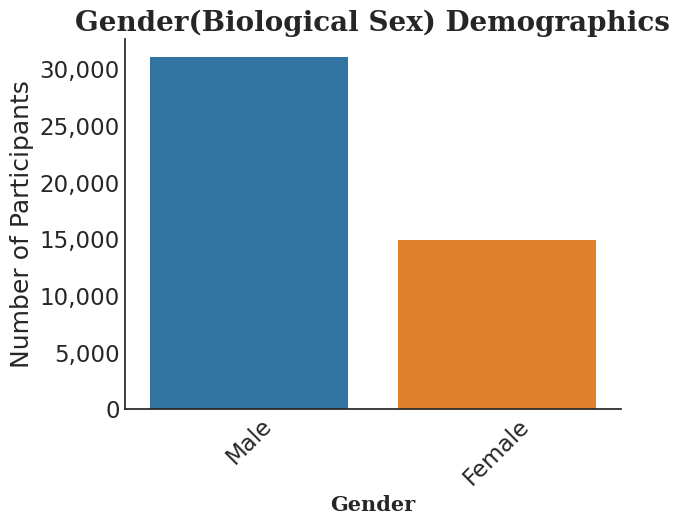

In [76]:
#create race countplot
sns.set_context('talk')
with plt.style.context('seaborn-white'):
  fig, ax =plt.subplots()
plt.rcParams['font.family'] = 'serif'
ax = sns.countplot(data=df,x='gender')
ax.set_title('Gender(Biological Sex) Demographics', fontfamily='serif',fontsize = 20, fontweight = 'bold');
ax.set_xlabel('Gender', fontfamily= 'serif', fontsize = 15, fontweight = 'bold')
plt.ylabel('Number of Participants')

#make commas in y ticks
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.xticks(rotation = 45);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False) 
plt.show()

### Summary
- This countplot shows a heavy weighting of males in the dataset that does not correlate to US Census data.
- Semantic confusion exists in labels because this is a biological sex category and does not include LGQTI+ designations.
#### Action plan: Look at gender(biological sex) and income.

In [ ]:
#create countplot for education
sns.set_context('talk')
with plt.style.context('seaborn-white'):
  fig, ax =plt.subplots()
plt.rcParams['font.family'] = 'serif'
ax = sns.countplot(data=df,x='edstatus')
ax.set_title('Education Status', fontfamily='serif',fontsize = 20, fontweight = 'bold');
ax.set_xlabel('Education by category', fontfamily= 'serif', fontsize = 15, fontweight = 'bold')
plt.xticks(rotation = 55);
ax.spines['right'].set_visible(False)

#make commas in y ticks
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}')) 

ax.spines['top'].set_visible(False) 
plt.show()
plt.savefig('Images/Education by Category', bbox_inches='tight')